# Jason Chalom Dec 2017 - Retro Rabbit Data Scientist Test
## Task 2: Modelling
### https://www.kaggle.com/dalpozz/creditcardfraud

# Please run each section in order
- Sections depend on work done before
- Insight and summaries are at the end

# Required Libraries
I made use of Python 3
Anaconda3 is recommended
Otherwise the required libraries:
- numpy
- pandas
- matplotlib
- seaborn
- sklearn

## TODO
1. Preprocess the data by performing appropriate data cleaning, transformations and feature selection
2. Suggest a technique to predict the target feature. Please write your answer in the notebook, and write why you suggest that model. Also please select appropriate performance measures
3. Run your selected technique and report on your results from using the technique
4. Given your results, suggest the next steps on how to further improve the model

In [1]:
# imports
# Seaborn was only used for more complicated graphs
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# My own implementation
import GMM as GMM

# 0. Load data (Need the csv file in the folder with the notebook)
data_file = "creditcard.csv"
df = pd.read_csv(data_file, delimiter=",", encoding="utf-8")

print("Shape of data:", df.values.shape)
print("Example Data:")
print(df.columns)
print(df.values[0])

# 1. clean up and normalise the data
# cleanup headings
df.columns = map(str.lower, df.columns)
df['class'] = df['class'].astype('bool')

# normalise data
# Used for boxplot
df_norm = (df.iloc[:,0:29]-df.iloc[:,0:29].mean())/df.iloc[:,0:29].std()

print("Data Import Done.")

Shape of data: (284807, 31)
Example Data:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
[  0.00000000e+00  -1.35980713e+00  -7.27811733e-02   2.53634674e+00
   1.37815522e+00  -3.38320770e-01   4.62387778e-01   2.39598554e-01
   9.86979013e-02   3.63786970e-01   9.07941720e-02  -5.51599533e-01
  -6.17800856e-01  -9.91389847e-01  -3.11169354e-01   1.46817697e+00
  -4.70400525e-01   2.07971242e-01   2.57905802e-02   4.03992960e-01
   2.51412098e-01  -1.83067779e-02   2.77837576e-01  -1.10473910e-01
   6.69280749e-02   1.28539358e-01  -1.89114844e-01   1.33558377e-01
  -2.10530535e-02   1.49620000e+02   0.00000000e+00]
Data Import Done.


Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')
range:	 [172792.0 58.86243962254021 94.7734565534212 57.70814779521654
 22.55851523176745 148.54497258781458 99.4621314818079 164.1467355164831
 93.22392682038871 29.0290609253579 48.333398557902 16.81638664641747
 26.5321067089889 12.918764164914599 29.7410915420461 13.37668627450898
 31.444966035120903 34.41632561979765 14.539815106458608 12.80549885751317
 93.91862474278591 62.03322130213 21.4362337876004 67.3361468935662
 7.42117605560158 17.81498575369426 6.12189616443197 54.177877426919004
 49.277891724418 25691.16 1]


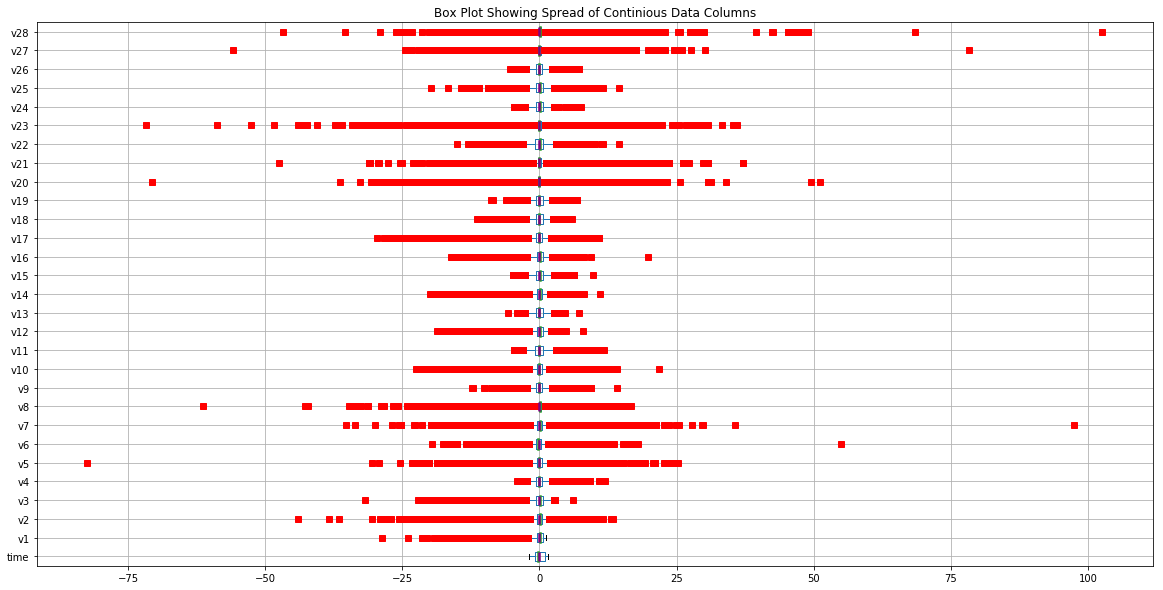

In [2]:
# 2. Stats / Looking at data
# Only really need the range since plots will have other info
min = np.min(df.values, axis=0)
max = np.max(df.values, axis=0)
mean = np.mean(df.values, axis=0)
print(df.columns)
# print("min:\t",min)
# print("max:\t",max)
print("range:\t", (max-min))
# print("mean:\t", mean)

# Box and whisker
# looking at outliers
plt.rcParams["figure.figsize"] = (20,10)
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
df_norm.boxplot(vert=False, sym='rs', showmeans=True, meanline=True, medianprops=medianprops, meanprops=meanlineprops)
plt.title("Box Plot Showing Spread of Continious Data Columns")
plt.show()

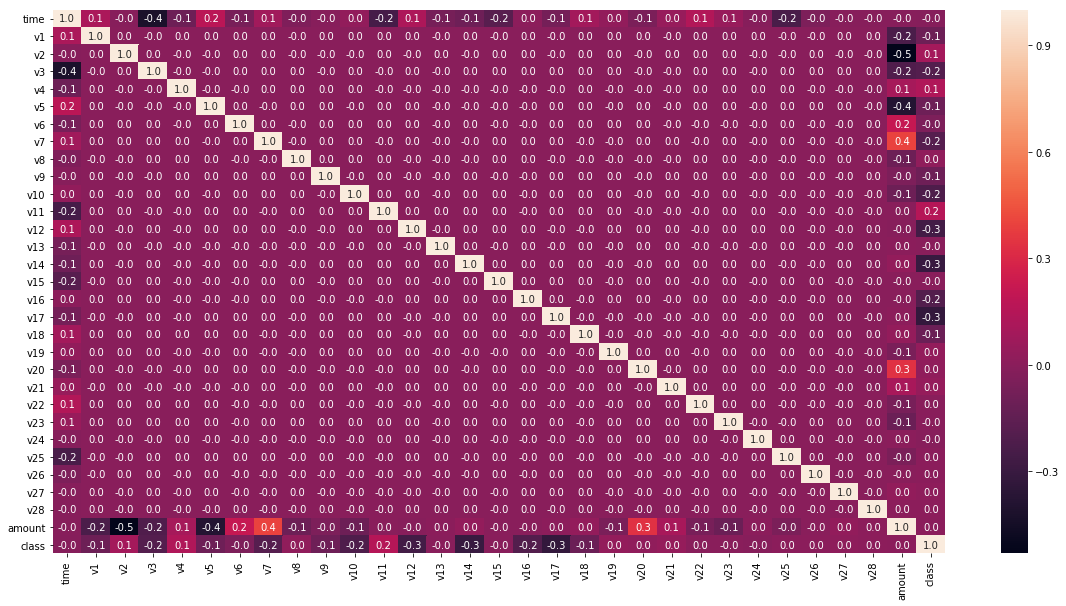

In [3]:
# 3. correlations
corr = df.corr()
sb.heatmap(corr, annot=True, fmt=".1f")
plt.yticks(rotation=0) 
plt.show()

# sb.pairplot(df)
# plt.show()

# Model Selection
Looking at (2) the box plot shows us that there are many outliers in the fields of the data. The model therefore needs to be robust against those kinds of outliers. The task here is to classify (cluster) the data records according to the class field. This means that clustering techniques may be used.

## Gaussian Mixture Models (GMM)
I have chosen to use a GMM because it is essentially a more general form of k-means clustering. k-means has issues with outliers and specific shapes/tendencies of data. GMM does have a weakness when it comes to singular co-variance matrices. Because of that only features which correlate can be selected.

### Performance Metrics
The data needs to be split up into training and test sets. A validation set is not needed in this case. The data rows will be initially randomised. The classification error count of each set will work as performance measurements of the model.

# Feature Selection
Looking at the complete dataset's cross-correlations, the features which correlate with the class field will be chosen to be used with the selected model.

## Selected Features
    - v1
    - v2
    - v3
    - v4
    - v5
    - v7
    - v9
    - v10
    - v11
    - v12
    - v14
    - v16
    - v17
    - v18

In [4]:
# 4. Split data
data_not_fraud = df[df['class'] == False]
data_fraud = df[df['class'] == True]

include = ['v1', 'v2', 'v3', 'v4', 'v5', 'v7', 'v9', 'v10', 'v11', 'v12', 'v14', 'v16', 'v17', 'v18']
cols = [col for col in df.columns if col in include]

data_not_fraud = data_not_fraud[cols]
data_fraud = data_fraud[cols]

# # shuffle rows
# data_not_fraud = shuffle(data_not_fraud)
# data_fraud = shuffle(data_fraud)

# Training, test and validation sets
train_not_fraud, test_not_fraud = train_test_split(data_not_fraud, test_size=0.2, shuffle=True)
# test_not_fraud, validation_not_fraud = train_test_split(test_complete_not_fraud, test_size=0.1, shuffle=True)

train_fraud, test_fraud = train_test_split(data_fraud, test_size=0.2, shuffle=True)
# test_fraud, validation_fraud = train_test_split(test_complete_fraud, test_size=0.1, shuffle=True)

print("done setting up data.")


done setting up data.


In [5]:
# 5. Train GMM

K = 2 #can be increased - train_fraud.shape[1]
print("K: ", K)
theta_fraud = GMM.train(train_fraud, K, training_size=train_fraud.shape[0], max_count = 2048, epsilon = 0.000001)
# theta_not_fraud = GMM.train(train_not_fraud, K, training_size=train_not_fraud.shape[0], max_count = 1024, epsilon = 0.00001)

# Calculate training error
label_vector = np.ones(train_fraud.shape[0], dtype=bool)
train_fraud_err = GMM.error(train_fraud, label_vector, theta_fraud, K)
print("train_fraud_err: ", train_fraud_err)

label_vector = np.zeros(train_not_fraud.shape[0], dtype=bool)
train_not_fraud_err = GMM.error(train_not_fraud, label_vector, theta_fraud, K)
print("train_not_fraud_err: ", train_not_fraud_err)

print("done training.")

K:  2
train_fraud_err:  0.43765903307888043
train_not_fraud_err:  0.7026273675324903
done training.


In [6]:
# 6. Error Measures
label_vector = np.zeros(test_fraud.shape[0], dtype=bool)
test_fraud_err = GMM.error(test_fraud, label_vector, theta_fraud, K)
print("test_fraud_err: ", test_fraud_err)

label_vector = np.zeros(test_not_fraud.shape[0], dtype=bool)
test_not_fraud_err = GMM.error(test_not_fraud, label_vector, theta_fraud, K)
print("test_not_fraud_err: ", test_not_fraud_err)


test_fraud_err:  0.5353535353535354
test_not_fraud_err:  0.7046233930675483


# Results of the Model
The model produced quite poor results when the classifier was tested using the test set. It works better at finding fraudulent transactions than finding good transactions. 

# Potential Improvements to the Model
Firstly multiple values for K should be chosen and their respective test errors should be compared. Also different types of covariance matrices should be tested for the GMM model. 

Another GMM model should be used for modelling non-fradulent cases. This is be much slower to train but then a more robust classifier can be used.

**Note:** I have found that there were some strange behaviours in my implementation of GMM. I then attempted to use the scikit learn GMM model but found that I had issues with the way it classifies the data (The reason I used this implementation in the first place). It is possible that there is a flaw in my logic or some other obtuse error which is producing these results. My feeling is that the issue lies with the classification side of my model.

